<a href="https://colab.research.google.com/gist/andreped/d40dbbd619867ac5fa26b640b19da815/ibdcolepi-load-dataset-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install OpenGL
!apt-get update && apt-get -y upgrade \
  && apt-get install -y \
    apt-utils \
    curl \
    xz-utils \
    ocl-icd-libopencl1 \
    opencl-headers \
    clinfo \
    python3-pip \
    ;
!mkdir -p /etc/OpenCL/vendors && \
    echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

# install OpenGL
!apt-get install -y \
    libopengl0 \
    libgl1 \
    libusb-1.0-0-dev \
    libcairo2

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,192 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:11 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main Sources [2,240 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:13 https://ppa.launchpadconte

In [2]:
!pip install -q datasets pyfast matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.8 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

# download data from Hugging Face hub might take several minute as each zip
# is about 2-10 GB each
dataset = load_dataset("andreped/IBDColEpi", "part_02")
print(dataset)

VERSION: 1.0.0


data is downloaded to: /root/.cache/huggingface/datasets/downloads/extracted/9e882e025d6646462b52ffdff5c28e8d80a6d4256b83efdc35b500e3bcea9a0d


Generating part_02 split: 0 examples [00:00, ? examples/s]

DatasetDict({
    part_02: Dataset({
        features: ['image'],
        num_rows: 25
    })
})


/root/.cache/huggingface/datasets/downloads/extracted/9e882e025d6646462b52ffdff5c28e8d80a6d4256b83efdc35b500e3bcea9a0d/ID-26_CD3_inactive.ndpi


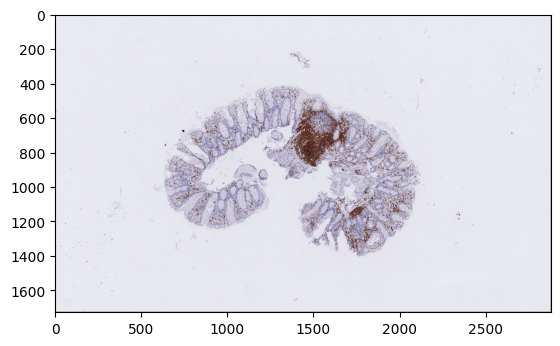

In [4]:
import fast

import matplotlib.pyplot as plt
import numpy as np

# Extract thumbnail image of the full WSI
filename = dataset["part_02"]["image"][0]
print(filename)

importer = fast.WholeSlideImageImporter.create(filename)

extractor = fast.ImagePyramidLevelExtractor.create(level=-1)
extractor.connect(importer)

thumbnail = extractor.runAndGetOutputData()
thumbnail = np.asarray(thumbnail)

plt.imshow(thumbnail)
plt.show()


In [5]:
import fast

import matplotlib.pyplot as plt
import numpy as np

# extract patches from 5x magnification from a WSI captured at 40x, and
# visualize them using matplotlib
# Extract thumbnail image of the full WSI
importer = fast.WholeSlideImageImporter.create(dataset["part_02"]["image"][0])

tissueSegmentation = fast.TissueSegmentation.create(threshold=85).connect(importer)

patchGenerator = fast.PatchGenerator.create(1024, 1024, magnification=5, overlapPercent=0.1, maskThreshold=0.1)\
    .connect(0, importer)\
    .connect(1, tissueSegmentation)

patch_list = []
for patch in fast.DataStream(patchGenerator):
    patch_list.append(patch)
    if len(patch_list) == 16:
        f, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i in range(4):
            for j in range(4):
                axes[i, j].imshow(patch_list[i + j * 3])
        patch_list.clear()
        break

In [6]:
from datasets import load_dataset

annotations = load_dataset("andreped/IBDColEpi", "annotations")
print(annotations)


data is downloaded to: /root/.cache/huggingface/datasets/downloads/extracted/141358d6b9d2fecfa38b7ac2cf6e5587f00d81948598f39876f03bfca06797d3


Generating annotations split: 0 examples [00:00, ? examples/s]

DatasetDict({
    annotations: Dataset({
        features: ['image'],
        num_rows: 251
    })
})


/root/.cache/huggingface/datasets/downloads/extracted/141358d6b9d2fecfa38b7ac2cf6e5587f00d81948598f39876f03bfca06797d3/ID-63_CD3_inactive.tiff


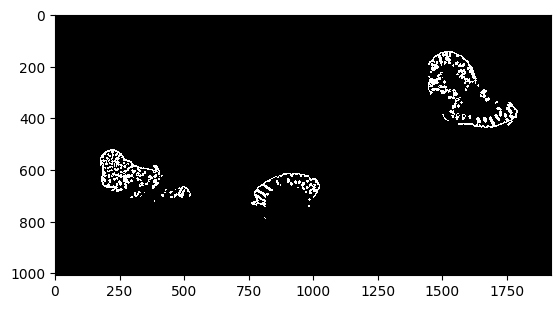

In [9]:
import fast

import matplotlib.pyplot as plt
import numpy as np

# Extract thumbnail image of both WSI and corresponding annotation and render
# them side-by-side
filename = annotations["annotations"]["image"][0]
print(filename)

importer = fast.TIFFImagePyramidImporter.create(annotations["annotations"]["image"][0])

extractor = fast.ImagePyramidLevelExtractor.create(level=5)
extractor.connect(importer)

thumbnail = extractor.runAndGetOutputData()
thumbnail = np.asarray(thumbnail)

plt.imshow(thumbnail.astype("uint8"), interpolation="none", cmap="gray")
plt.show()

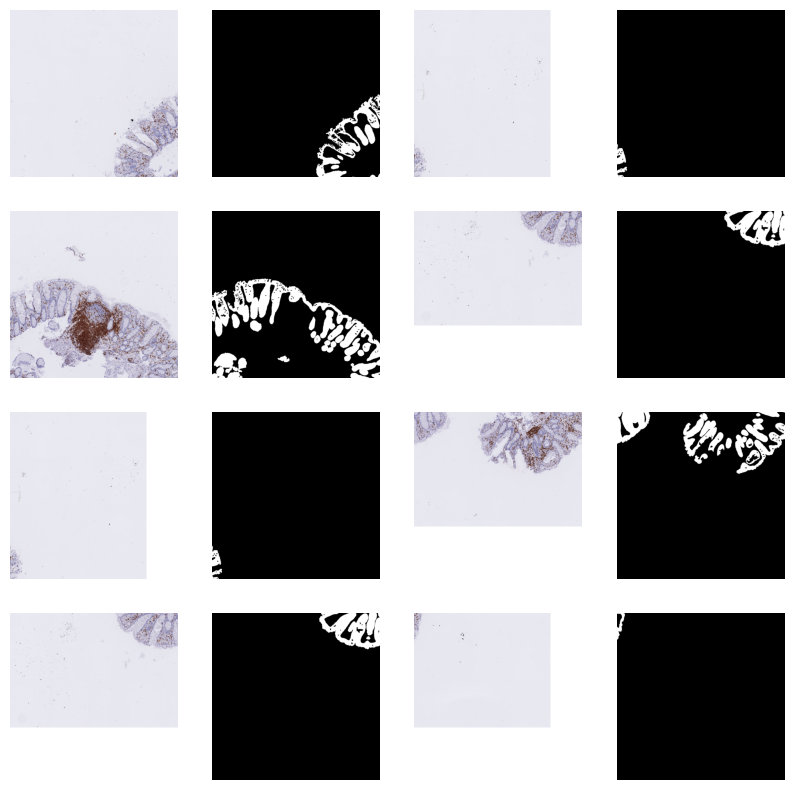

In [10]:
import os
import fast

import matplotlib.pyplot as plt
import numpy as np

# Extract patches from WSI and corresponding GT and display them together
filename = dataset["part_02"]["image"][0]
gt_filename = "/".join(annotations["annotations"]["image"][0].split("/")[:-1]) + "/" + filename.split("/")[-1].split(".")[0] + ".tiff"

importer = fast.WholeSlideImageImporter.create(filename)
gt_importer = fast.TIFFImagePyramidImporter.create(gt_filename)

patchGenerator = fast.PatchGenerator.create(1024, 1024, level=3, overlapPercent=0)\
    .connect(0, importer)

gt_patchGenerator = fast.PatchGenerator.create(1024, 1024, level=3, overlapPercent=0)\
    .connect(0, gt_importer)

patch_list = []
for patch, gt_patch in zip(fast.DataStream(patchGenerator), fast.DataStream(gt_patchGenerator)):
    patch_list.append([patch, gt_patch])
    if len(patch_list) == 8:
        break

f, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(2):
        axes[i, int(2 * j)].imshow(patch_list[i + int(2 * j)][0])
        axes[i, int(2 * j) + 1].imshow(patch_list[i + int(2 * j)][1], cmap="gray")
        axes[i, int(2 * j)].axis("off")
        axes[i, int(2 * j) + 1].axis("off")
patch_list.clear()

plt.show()
